In [2]:
import os
if "notebooks" not in os.listdir(): 
    os.chdir("..")
    print(os.getcwd())

import pandas as pd
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import numpy as np
from torch.utils.data import DataLoader
from torch.utils.data import Dataset
from pathlib import Path
import pickle
from tqdm import tqdm

import sys
import os
from typing import *
import numpy as np
from torch.utils.data import DataLoader
import random
import pickle
import copy
sys.path.append(os.path.dirname(os.path.dirname(os.getcwd())))
from mmhb.loader import MMDataset
from PIL import Image
import torchvision.transforms as transforms
from mmhb.utils.mimic_utils import add_timeseries_noise, add_tabular_noise

%load_ext autoreload
%autoreload 2

/home/kh701/pycharm/mm-lego


In [3]:
isic_path = Path("/auto/archive/tcga/other_data/ISIC/")

# note: can only use training data (no labels for test)
df = pd.read_csv(isic_path.joinpath("train.csv"), index_col="patient_id")
img_index = df["image_name"]
targets = df["target"]
df = df.drop(columns=["image_name", "target"])

# one-hot encode
one_hot_cols = ["sex", "anatom_site_general_challenge", "diagnosis", "benign_malignant"]

df = pd.get_dummies(df, columns=one_hot_cols, dtype="int")






In [59]:
class ISICDataset(MMDataset): 
    
    def __init__(self, 
                 data_path: Union[str, Path], 
                 expand: bool = False, 
                 modalities: List = ["tab", "img"], 
                 concat: bool = False, 
                 dataset: str = "isic",
                 **kwargs
                 ):
        
        super().__init__(
            data_path=data_path, expand=expand, modalities=modalities, **kwargs
        )
        
        self.concat = concat
        self.dataset = dataset
        
        self.df = pd.read_csv(data_path.joinpath("train.csv"), index_col="patient_id")
        self.img_index = self.df["image_name"]
        self.img_path = self.data_path.joinpath("img_prep")
        self.targets = torch.Tensor(self.df["target"].values).int()
        # self.targets = torch.Tensor(self.df.loc[:, "target"])
        one_hot_cols = ["sex", "anatom_site_general_challenge", "diagnosis", "benign_malignant"] 
        # one-hot encode
        self.df = pd.get_dummies(self.df, columns=one_hot_cols, dtype="int")
        self.df = self.df.drop(columns=["image_name", "target"])
        
        self.X_tab = torch.Tensor(self.df.values)
        
        
    def __len__(self):
        return len(self.df)
    
    def _get_img(self, idx):
        # load_path = self.
        load_path = self.img_path.joinpath(f"{self.img_index.iloc[idx]}.pt")
        return torch.load(load_path)
        
    def __getitem__(self, idx): 
        tensors = []
        if "tab" in self.modalities: 
            tensor = self.X_tab[idx]
            if self.expand: 
                tensor = tensor.unsqueeze(0)
            tensors.append(tensor)
        if "img" in self.modalities:
            tensors.append(self._get_img(idx))
        
        return tensors, self.targets[idx]
        

isic = ISICDataset(
    # data_path = Path("/auto/archive/tcga/other_data/ISIC/"),
    data_path = Path("../mm-lego/data/isic/"), 
    expand=True
)

[2024-05-12 14:36:00][INFO][base][__init__:41] Using device: cuda


In [60]:
(tab, img), target = isic[0]
print(tab.shape, img.shape)

torch.Size([1, 20]) torch.Size([15, 2048])


In [58]:
target

tensor(0, dtype=torch.int32)

In [24]:
import torch
import torchvision.models as models
from torchvision.transforms.functional import to_tensor
from PIL import Image

def preprocess(img_path: Path, patch_dims: int = 3) -> torch.Tensor:  
    # Load a pre-trained ResNet model
    model = models.resnet50(weights="ResNet50_Weights.DEFAULT")
    # Remove the last layer (classification layer)
    model = torch.nn.Sequential(*(list(model.children())[:-1]))

    device = "cuda" if torch.cuda.is_available() else "cpu"
    model.to(device)

    # Function to divide an image into patches
    def get_patches(image, patch_size=224, stride=224):
        patches = []
        for i in range(0, image.width, stride):
            for j in range(0, image.height, stride):
                patch = image.crop((i, j, i + patch_size, j + patch_size))
                patches.append(patch)
        return patches

    # Load the image
    image = Image.open(img_path)
    
    
    # resize image to nxn patches
    image = image.resize((int(1.5* patch_dims * 224), patch_dims * 224))

    # Get patches
    patches = get_patches(image)

    # Encode each patch
    encoded_patches = [] # treat as tensor
    for i, patch in enumerate(patches):
        # Convert the patch to a tensor and add a batch dimension
        patch_tensor = to_tensor(patch).unsqueeze(0)
        patch_tensor = patch_tensor.to(device)
        
        print(f"Processing patch {i + 1}/{len(patches)}")
        # Pass the patch through the model
        encoded_patch = model(patch_tensor)
        # Remove the batch dimension and add the encoded patch to the list
        encoded_patches.append(encoded_patch.squeeze())
    # convert to tensor
    encoded_patches = torch.stack(encoded_patches)

    return encoded_patches
    

In [25]:
# load pil image
isic_path = Path("/auto/archive/tcga/other_data/ISIC/")

# # note: can only use training data (no labels for test)
df = pd.read_csv(isic_path.joinpath("train.csv"), index_col="patient_id")
img_index = df["image_name"]
img_path = isic_path.joinpath("jpeg/train").joinpath(f"{img_index.iloc[0]}.jpg")

prep_img = preprocess(img_path)
# 
# 
# for i in range(10):
#     img = Image.open(isic_path.joinpath("jpeg/train").joinpath(f"{img_index.iloc[i]}.jpg"))
#     patches = preprocess(img)
#     print(patches)
#     # print(img.size)


# img = Image.open(isic.img_path.joinpath(f"{isic.img_index.iloc[0]}.jpg"))

Processing patch 1/15
Processing patch 2/15
Processing patch 3/15
Processing patch 4/15
Processing patch 5/15
Processing patch 6/15
Processing patch 7/15
Processing patch 8/15
Processing patch 9/15
Processing patch 10/15
Processing patch 11/15
Processing patch 12/15
Processing patch 13/15
Processing patch 14/15
Processing patch 15/15


In [26]:
prep_img.shape

torch.Size([15, 2048])

In [12]:
len(prep_img)

9

In [ ]:
img = isic._get_img(2)
pil = transforms.ToPILImage()
plt.imshow(pil(img))
plt.show()

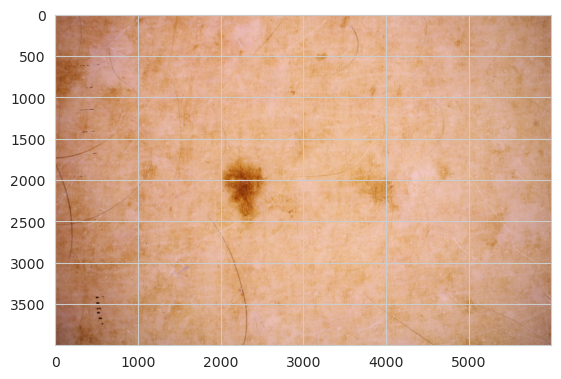

In [54]:
pil = transforms.ToPILImage()
plt.imshow(pil(img))
plt.show()

In [24]:
df.head()

,image_name,patient_id,sex,age_approx,anatom_site_general_challenge,diagnosis,benign_malignant,target
0,ISIC_2637011,IP_7279968,male,45.0,head/neck,unknown,benign,0
1,ISIC_0015719,IP_3075186,female,45.0,upper extremity,unknown,benign,0
2,ISIC_0052212,IP_2842074,female,50.0,lower extremity,nevus,benign,0
3,ISIC_0068279,IP_6890425,female,45.0,head/neck,unknown,benign,0
4,ISIC_0074268,IP_8723313,female,55.0,upper extremity,unknown,benign,0


In [23]:
(df.target.value_counts() / len(df)).sort_index()

target
0    0.98237
1    0.01763
Name: count, dtype: float64